In [1]:
from cil.optimisation.functions import L2NormSquared, MixedL21Norm
from cil.optimisation.operators import DiagonalOperator, CompositionOperator,FiniteDifferenceOperator, IdentityOperator, BlockOperator
from cil.optimisation.algorithms import PDHG
from cil.utilities.display import show2D
from cil.utilities import dataexample
from cvxpy import *
from regularisers import dtv
import numpy as np
import matplotlib.pyplot as plt

# Load Data and resize

In [2]:
data = dataexample.CAMERA.get(size=(32, 32))

# Setup and run directional tv denoising with cvxpy

In [3]:
# Reference image
reference = data * 0.01

# Construct problem    
u_cvx = Variable(data.shape)

# fidelity
fidelity = sum_squares(u_cvx - data.array)   

# regulariser
eta = 0.1
alpha = 0.5
regulariser = alpha * dtv(u_cvx, reference, eta) 
constraints = []

obj =  Minimize( regulariser +  fidelity)
prob = Problem(obj, constraints)

# Choose solver (SCS is fast but less accurate than MOSEK)
res = prob.solve(verbose = True, solver = SCS, eps=1e-5)

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Dec 06 07:28:42 PM: Your problem has 1024 variables, 0 constraints, and 0 parameters.
(CVXPY) Dec 06 07:28:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 06 07:28:42 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 06 07:28:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 06 07:28:42 PM: Compiling problem (target solver=SCS).
(CVXPY) Dec 06 07:28:42 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.w

----------------------------------------------------------------------------
	SCS v2.1.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 7584
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 2049, constraints m = 4098
Cones:	soc vars: 4098, soc blks: 1025
Setup time: 1.07e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.86e+20  6.62e+20  1.00e+00 -1.16e+23  6.37e+21  2.54e+22  1.14e-02 
   100| 4.60e-05  1.32e-04  9.88e-07  2.93e+01  2.93e+01  7.91e-15  3.15e-01 
   200| 1.57e-05  3.83e-05  3.18e-06  2.93e+01  2.93e+01  2.79e-14  5.97e-01 
   300| 1.38e-05  3.19e-05  1.2

# Setup 2D directional TV denoising, using CIL and the PDHG algorithm

In [4]:
ig = data.geometry

# fidelity term
g = L2NormSquared(b=data)

# setup operator for directional TV
DY = FiniteDifferenceOperator(ig, direction=1)
DX = FiniteDifferenceOperator(ig, direction=0)

Grad = BlockOperator(DY, DX)
grad_ref = Grad.direct(reference)
denom = (eta**2 + grad_ref.pnorm(2)**2).sqrt()
xi = grad_ref/denom

A1 = DY - CompositionOperator(DiagonalOperator(xi[0]**2),DY) - CompositionOperator(DiagonalOperator(xi[0]*xi[1]),DX)
A2 = DX - CompositionOperator(DiagonalOperator(xi[0]*xi[1]),DY) - CompositionOperator(DiagonalOperator(xi[1]**2),DX)

operator = BlockOperator(A1, A2)

f = alpha * MixedL21Norm()

# use primal acceleration due to g being strongly convex
pdhg = PDHG(f = f, g = g, operator = operator, 
            max_iteration=500, update_objective_interval = 100, gamma_g = 1.)
pdhg.run(verbose=2)

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        500         0.000    4.30843e+02  -0.00000e+00    4.30843e+02


/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/optimisation/algorithms/PDHG.py:358: UserWarning: Primal Acceleration of PDHG: The function g is assumed to be strongly convex with positive parameter `gamma_g`. You need to be sure that gamma_g = 1.0 is the correct strongly convex constant for g. 
  warnings.warn("Primal Acceleration of PDHG: The function g is assumed to be strongly convex with positive parameter `gamma_g`. You need to be sure that gamma_g = {} is the correct strongly convex constant for g. ".format(self.gamma_g))
/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/framework/framework.py:2421: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      100        500         0.044    2.93090e+01   2.92706e+01    3.83387e-02
      200        500         0.043    2.92777e+01   2.92733e+01    4.36878e-03
      300        500         0.043    2.92747e+01   2.92733e+01    1.39904e-03
      400        500         0.041    2.92745e+01   2.92735e+01    1.02711e-03
      500        500         0.037    2.92737e+01   2.92735e+01    2.34604e-04
----------------------------------------------------------------------------
      500        500         0.037    2.92737e+01   2.92735e+01    2.34604e-04
Stop criterion has been reached.



# Compare solutions

CVX objective = 29.273819440563372
CIL objective = 29.273714065551758


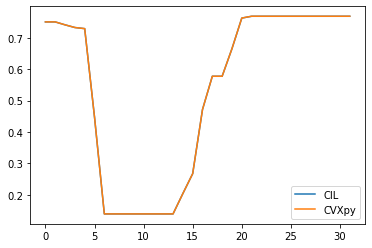

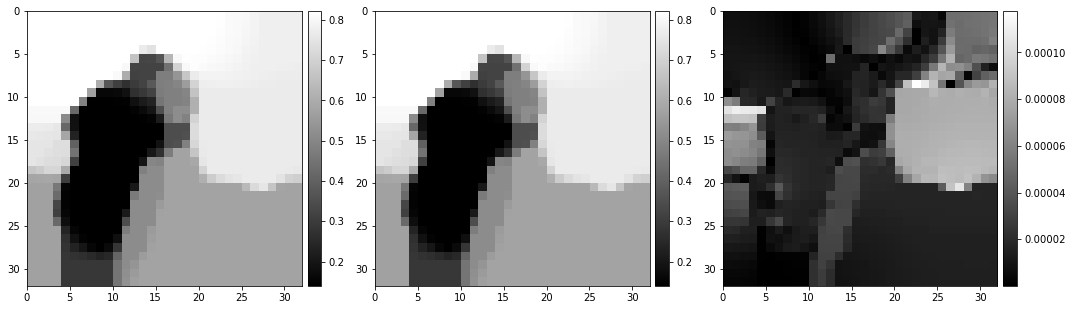

In [6]:
np.testing.assert_almost_equal(pdhg.solution.array, u_cvx.value, decimal=3)

# print objectives
print("CVX objective = {}".format(obj.value))

print("CIL objective = {}".format(pdhg.objective[-1]))

# show middle line profiles
N, M = data.shape
plt.figure()
plt.plot(pdhg.solution.array[int(N/2)], label="CIL")
plt.plot(u_cvx.value[int(N/2)], label="CVXpy")
plt.legend()
plt.show()

show2D([pdhg.solution.array, u_cvx.value, np.abs(pdhg.solution.array - u_cvx.value)], num_cols = 3, origin="upper")
